## 모델링

In [65]:
!pip install --upgrade pip

   ---------------------------------------- 0.0/2.1 MB ? eta -:--:--
   ---------------------------------------- 0.0/2.1 MB ? eta -:--:--
    --------------------------------------- 0.0/2.1 MB 660.6 kB/s eta 0:00:04
   --- ------------------------------------ 0.2/2.1 MB 1.4 MB/s eta 0:00:02
   ------ --------------------------------- 0.4/2.1 MB 2.5 MB/s eta 0:00:01
   ---------- ----------------------------- 0.5/2.1 MB 3.0 MB/s eta 0:00:01
   -------------- ------------------------- 0.8/2.1 MB 3.2 MB/s eta 0:00:01
   --------------- ------------------------ 0.8/2.1 MB 2.8 MB/s eta 0:00:01
   ------------------- -------------------- 1.0/2.1 MB 3.3 MB/s eta 0:00:01
   --------------------- ------------------ 1.1/2.1 MB 3.1 MB/s eta 0:00:01
   -------------------------- ------------- 1.4/2.1 MB 3.3 MB/s eta 0:00:01
   ------------------------------- -------- 1.6/2.1 MB 3.5 MB/s eta 0:00:01
   ---------------------------------------  2.1/2.1 MB 4.1 MB/s eta 0:00:01
   ---------------------

'DOSKEY'��(��) ���� �Ǵ� �ܺ� ����, ������ �� �ִ� ���α׷�, �Ǵ�
��ġ ������ �ƴմϴ�.


In [66]:
!pip install catboost,xgboost,lightgbm

'DOSKEY'��(��) ���� �Ǵ� �ܺ� ����, ������ �� �ִ� ���α׷�, �Ǵ�
��ġ ������ �ƴմϴ�.
ERROR: Invalid requirement: 'catboost,xgboost,lightGBM'


In [129]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.tree import DecisionTreeRegressor, plot_tree
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import *
from lightgbm import LGBMRegressor
from catboost import CatBoostRegressor
from xgboost import XGBRegressor

from sklearn.preprocessing import MinMaxScaler
from sklearn.svm import SVR
from sklearn.neighbors import KNeighborsRegressor, KNeighborsClassifier
from sklearn.metrics import *

import tensorflow as tf
from keras.models import Sequential
from keras.layers import Dense,Flatten
from keras.backend import clear_session

In [105]:
# 변수중요도 plot 함수
def plot_feature_importance(importance, names, topn = 'all'):
    feature_importance = np.array(importance)
    feature_names = np.array(names)

    data={'feature_names':feature_names,'feature_importance':feature_importance}
    fi_temp = pd.DataFrame(data)

    fi_temp.sort_values(by=['feature_importance'], ascending=False,inplace=True)
    fi_temp.reset_index(drop=True, inplace = True)

    if topn == 'all' :
        fi_df = fi_temp.copy()
    else :
        fi_df = fi_temp.iloc[:topn]

    plt.figure(figsize=(10,8))
    sns.barplot(x='feature_importance', y='feature_names', data = fi_df)

    plt.xlabel('importance')
    plt.ylabel('feature names')
    plt.grid()

    return fi_df

In [69]:
path='../../data/preprocessed data/'

In [99]:
data=pd.read_csv(path+'dong_service_data.csv')
data.shape

(191994, 175)

In [94]:
data.isna().sum().sum()

501480

In [100]:
data.dtypes

기준_년분기_코드       int64
행정동_코드          int64
행정동_코드_명       object
서비스_업종_코드      object
서비스_업종_코드_명    object
                ...  
수요일_유동인구_수      int64
목요일_유동인구_수      int64
금요일_유동인구_수      int64
토요일_유동인구_수      int64
일요일_유동인구_수      int64
Length: 175, dtype: object

In [101]:
# 19년도 데이터 임시로 제거(na값들 제거하기위해)
data = data[~data['기준_년분기_코드'].isin([20191, 20192,20193,20194])]
data['기준_년분기_코드'].unique()

array([20221, 20222, 20223, 20224, 20231, 20232, 20201, 20202, 20203,
       20204, 20211, 20212, 20213, 20214], dtype=int64)

In [103]:
data.isna().sum().sum()


0

In [106]:
drop_col=['행정동_코드_명','서비스_업종_코드_명']
data=data.drop(columns=drop_col)

In [107]:
# 행정동코드, 업종코드로 입력 받음 / train_test_split 반환
def data_filter_split(dataframe,행정동코드, 업종코드):
    # 해당 데이터프레임 추출
    filtered_df = dataframe[(dataframe['행정동_코드'] == 행정동코드) & (dataframe['서비스_업종_코드'] == 업종코드)]
    
    # x,y 분리
    target='당월_매출_금액'
    x = filtered_df.drop([target,'행정동_코드','서비스_업종_코드'], axis = 1)
    y = filtered_df.loc[:,target]
    
    # return x_train, x_val, y_train, y_val
    return train_test_split(x, y, test_size = .2, random_state = 20)

# 데이터 스케일링 
def data_filter_split2(dataframe,행정동코드, 업종코드):
    # 해당 데이터프레임 추출
    filtered_df = dataframe[(dataframe['행정동_코드'] == 행정동코드) & (dataframe['서비스_업종_코드'] == 업종코드)]
    
    # x,y 분리
    target='당월_매출_금액'
    x = filtered_df.drop([target,'행정동_코드','서비스_업종_코드'], axis = 1)
    y = filtered_df.loc[:,target]
    
    scaler=MinMaxScaler()
    x_s=scaler.fit_transform(x)
    
    # return x_train, x_val, y_train, y_val
    return train_test_split(x_s, y, test_size = .2, random_state = 20)


def model_train_pred_metric(model,x_train, x_val, y_train, y_val):
    
    # train
    model.fit(x_train,y_train)
    y_pred=model.predict(x_val)
    
    # return metrics - rmse
    return np.sqrt(mean_squared_error(y_val,y_pred))
    
    

#### ML Model: Decision Tree, RandomForest, SVM, Catboost, lgbm, knn_R, XGB

In [136]:
model_dt = DecisionTreeRegressor(max_depth = 5,random_state=42)
model_rf=RandomForestRegressor(max_depth=5,random_state=42)
model_svm=SVR()
model_cb=CatBoostRegressor(iterations=100, depth=5, learning_rate=0.01, loss_function='RMSE',random_state=42,verbose=0)
model_lgbm=LGBMRegressor(n_estimators=100, learning_rate=0.01, max_depth=5, random_state=42)
model_knn=KNeighborsRegressor(n_neighbors=5)
model_xgb = XGBRegressor(n_estimators=100, learning_rate=0.01, max_depth=5, random_state=42)

### DL model

In [137]:
model_dl = tf.keras.Sequential([
    Flatten(),
    Dense(units=64, activation='relu'),
    Dense(units=32, activation='relu'),             
    Dense(units=1, activation='linear')              
])

# 모델 컴파일
model_dl.compile(optimizer='sgd', loss='mean_squared_error')

In [124]:
# 사용모델
model_name=["Decision Tree","Random Forest"," SVM","CatBoost","LightGB","KNN","XGB","DL"]

model_list=[model_dt,model_rf,model_svm,model_cb,model_lgbm,model_knn,model_xgb,model_dl]

In [115]:
# 예시 1. 청운효자동, 한식음식점 입력받음
# 11110515: 청운효자동 , 한식음식점: CS100001
input1,input2=11110515,'CS100001'

In [149]:
res_list=[]
need_scale=["SVM","KNN","DL"]
for x in range(8):
    
    if model_name[x]=="CatBoost":continue
    if model_name[x]=="DL":continue
    
    # 스케일링 필요시 
    if model_name[x] in need_scale:
        x_train, x_val, y_train, y_val=data_filter_split2(data,input1,input2)
    else:
        x_train, x_val, y_train, y_val=data_filter_split(data,input1,input2)
    
    res=model_train_pred_metric(model_list[x],x_train, x_val, y_train, y_val)
    print(f'모델  : {model_name[x]}\n rmse : {res}')
    res_list.append(res)

모델  : Decision Tree
 rmse : 140961750.14014372
모델  : Random Forest
 rmse : 168212231.13029993
모델  :  SVM
 rmse : 964153285.0920627
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Warning] There are no meaningful features which satisfy the provided configuration. Decreasing Dataset parameters min_data_in_bin or min_data_in_leaf and re-constructing Dataset might resolve this warning.
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Info] Total Bins 0
[LightGBM] [Info] Number of data points in the train set: 20, number of used features: 0
[LightGBM] [Info] Start training from score 3545462540.800000
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[

In [151]:
len(model_name),len(res_list)

(8, 6)

In [153]:
for x,y in zip(model_name,res_list):
    if x=="CatBoost":continue
    if x=="DL":continue
    print(f'모델  : {x}\n rmse : {y}')

모델  : Decision Tree
 rmse : 140961750.14014372
모델  : Random Forest
 rmse : 168212231.13029993
모델  :  SVM
 rmse : 964153285.0920627
모델  : LightGB
 rmse : 288028656.1017303
모델  : KNN
 rmse : 458452263.67446494


#### ㅁ델 시각화

In [51]:

plt.figure(figsize = (20, 8))
plot_tree(model, feature_names = x.columns,
          filled = True, fontsize = 10)
plt.show()

InvalidParameterError: The 'feature_names' parameter of plot_tree must be an instance of 'list' or None. Got Index(['기준_년분기_코드', '당월_매출_건수', '주중_매출_금액', '주말_매출_금액', '월요일_매출_금액',
       '화요일_매출_금액', '수요일_매출_금액', '목요일_매출_금액', '금요일_매출_금액', '토요일_매출_금액',
       ...
       '시간대_14_17_유동인구_수', '시간대_17_21_유동인구_수', '시간대_21_24_유동인구_수',
       '월요일_유동인구_수', '화요일_유동인구_수', '수요일_유동인구_수', '목요일_유동인구_수', '금요일_유동인구_수',
       '토요일_유동인구_수', '일요일_유동인구_수'],
      dtype='object', length=170) instead.

<Figure size 2000x800 with 0 Axes>

#### 변수 중요도

C:\Users\user\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\IPython\core\events.py:93: UserWarning: Glyph 51068 (\N{HANGUL SYLLABLE IL}) missing from current font.
  func(*args, **kwargs)
C:\Users\user\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\IPython\core\events.py:93: UserWarning: Glyph 50836 (\N{HANGUL SYLLABLE YO}) missing from current font.
  func(*args, **kwargs)
C:\Users\user\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\IPython\core\events.py:93: UserWarning: Glyph 47588 (\N{HANGUL SYLLABLE MAE}) missing from current font.
  func(*args, **kwargs)
C:\Users\user\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\IPython\core\events.py:93: UserWarning: Glyph 52636 (\N{HANGUL 

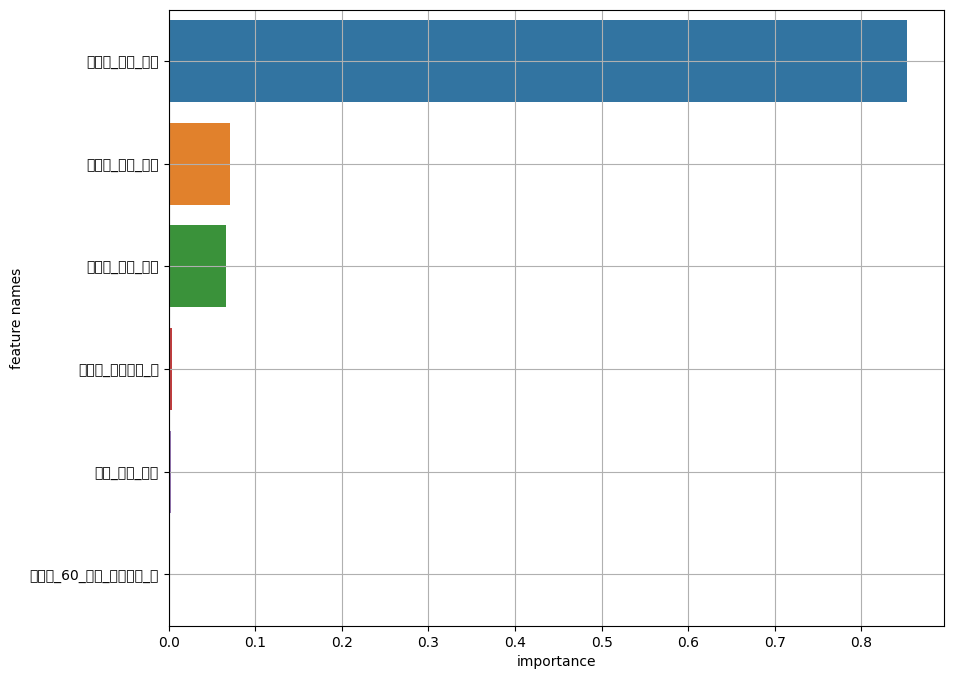

In [52]:
result = plot_feature_importance(model.feature_importances_, list(x), 6)